In [3]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

import tqdm as tqdm

import numpy as np
from scipy import stats
# Plots have dimension (w,h)
w = 3.5
h = 3.25 

import sklearn.metrics as metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check Initialization

## Dat 5

In [337]:
dat_5_loss = np.load('flows/dat/5/losses.npy')
dat_5_loss = dat_5_loss[dat_5_loss > 0]

(10.0, 12.0)

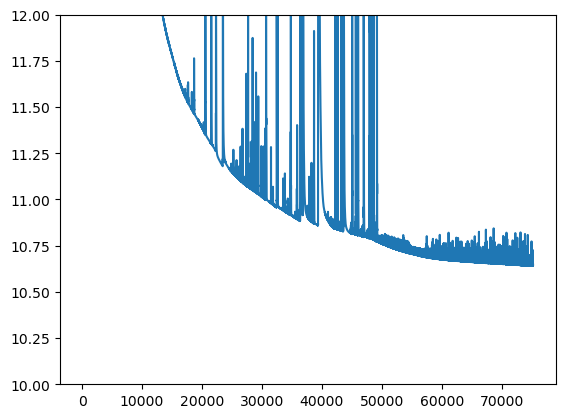

In [338]:
plt.plot(dat_5_loss)
plt.ylim(10, 12)

In [339]:
min(dat_5_loss)

10.641048431396484

## Sim 5

In [340]:
sim_5_loss = np.load('flows/sim/5/losses.npy')
sim_5_loss = sim_5_loss[sim_5_loss > 0]

(10.0, 12.0)

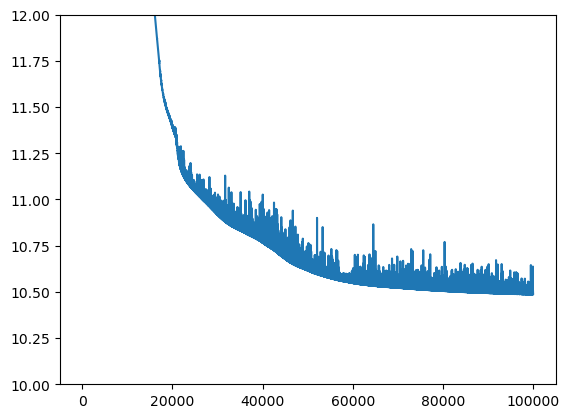

In [341]:
plt.plot(sim_5_loss)
plt.ylim(10, 12)

In [342]:
min(sim_5_loss)

10.486039161682129

## Dat 6

In [313]:
dat_6_loss = np.load('flows/dat/6/losses.npy')
dat_6_loss

array([2.16765625e+04, 5.18990869e+03, 2.80529810e+03, ...,
       9.71032715e+00, 9.71135807e+00, 9.71076202e+00])

In [314]:
dat_6_loss = np.load('flows/dat/6/losses.npy')
dat_6_loss = dat_6_loss[dat_6_loss > 0]

(9.5, 10.5)

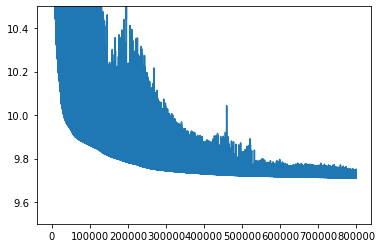

In [315]:
plt.plot(dat_6_loss)
plt.ylim(9.5, 10.5)

In [316]:
min(dat_6_loss)

9.709952354431152

## Sim 6

In [317]:
sim_6_loss = np.load('flows/sim/6/losses.npy')
sim_6_loss

array([3.43289155e+12, 5.39123712e+11, 4.99847373e+10, ...,
       9.79120350e+00, 9.78930950e+00, 9.78984642e+00])

In [318]:
sim_6_loss = np.load('flows/sim/6/losses.npy')
sim_6_loss = sim_6_loss[sim_6_loss > 0]

(9.5, 10.5)

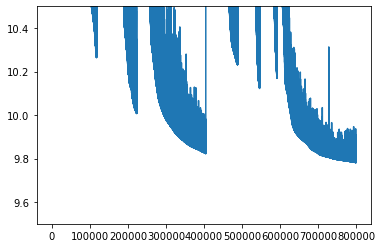

In [319]:
plt.plot(sim_6_loss)
plt.ylim(9.5, 10.5)

In [320]:
min(sim_6_loss)

9.781550407409668

## Sim 7

In [7]:
sim_7_loss = np.load('flows/sim/7/losses.npy')
sim_7_loss

array([4.73420680e+19, 3.09380472e+19, 2.22738516e+19, ...,
       9.93947029e+00, 9.93958664e+00, 9.93954277e+00])

In [8]:
sim_7_loss = np.load('flows/sim/7/losses.npy')
sim_7_loss = sim_7_loss[sim_7_loss > 0]

(0.0, 100.0)

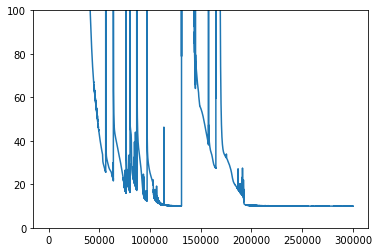

In [9]:
plt.plot(sim_7_loss)
plt.ylim(0, 100)

In [537]:
min(sim_7_loss)

20890522.0

# Validation

In [321]:
def ratio_hist(truth, fit,
               labels,
               color = "gray",
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               n_bins = 51,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    
    truth = truth[(truth > x_lim[0]) & (truth < x_lim[1])]
    fit = fit[(fit > x_lim[0]) & (fit < x_lim[1])]
    
    bins = np.linspace(x_lim[0], x_lim[1], n_bins)
    
    t_hist = axs[0].hist(truth, bins = bins, density = True, color = color, alpha = 0.25, label = labels[0])
    f_hist = axs[0].hist(fit, bins = bins, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    axs[0].minorticks_on()
    axs[0].tick_params(direction='in', which='both')
    axs[0].legend()
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
    axs[1].axhline(1,color="gray", lw=0.5)
    
    axs[1].minorticks_on()
    axs[1].tick_params(direction='in', which='both')
    axs[1].set_ylim(0, 2)
    
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

## Load in 5-Vectors

In [450]:
# Load in data.
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

mc_pt =  mc['sim_jets'][:, 0] 
mc_eta = mc['sim_jets'][:, 1]
mc_phi = mc['sim_jets'][:, 2]
mc_m =   mc['sim_jets'][:, 3]
mc_w = mc['sim_widths']
mc_sdms = mc['sim_sdms']

mc = np.vstack([mc_pt, mc_eta, mc_m, mc_w, mc_sdms]).T


dt = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dt_pt =  dt['sim_jets'][:, 0] 
dt_eta = dt['sim_jets'][:, 1]
dt_phi = dt['sim_jets'][:, 2]
dt_m =   dt['sim_jets'][:, 3]
dt_w = dt['sim_widths']
dt_sdms = dt['sim_sdms']

dt = np.vstack([dt_pt, dt_eta, dt_m, dt_w, dt_sdms]).T

n, d = mc.shape

In [451]:
num_layers = 5
base_dist = StandardNormal(shape=[d])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=d))
    transforms.append(MaskedAffineAutoregressiveTransform(features=d, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

## Dat 5

In [452]:
experiment = 'flows/dat/5'

In [453]:
ckpt = torch.load('flows/dat/5/ckpt_best')
flow.load_state_dict(ckpt['model_state_dict'])
flow.eval()

dat_smp = flow.sample(n).detach().numpy()

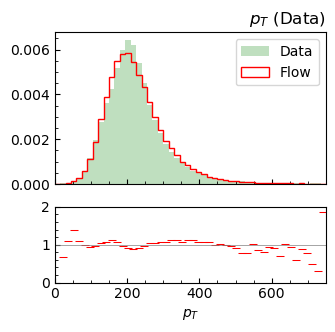

In [454]:
ratio_hist(dt[:, 0], dat_smp[:, 0], 
           labels = ['Data', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'$p_T$ (Data)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/{}/pT.png'.format(experiment)
          )

/tmp/ipykernel_15872/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


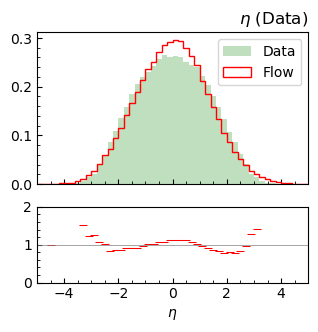

In [455]:
ratio_hist(dt[:, 1], dat_smp[:, 1], 
           labels = ['Data', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'$\eta$ (Data)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/{}/eta.png'.format(experiment)
          )

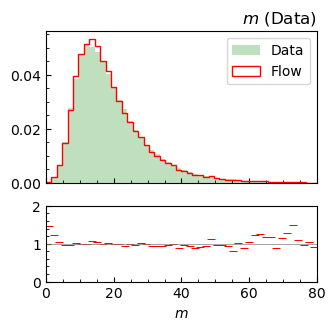

In [456]:
ratio_hist(dt[:, 2], dat_smp[:, 2], 
           labels = ['Data', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'$m$ (Data)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/{}/m.png'.format(experiment)
          )

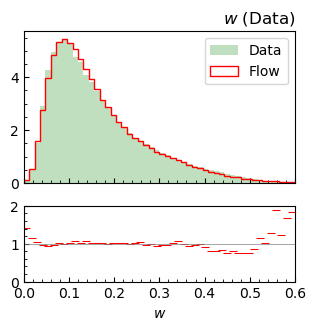

In [457]:
ratio_hist(dt[:, 3], dat_smp[:, 3], 
           labels = ['Data', 'Flow', r'$w$'],
           color = 'green',
           figsize = (w, h),
           title = r'$w$ (Data)',
           x_lim = (0, 0.6),
           filename = '../plots/zenodo/flows/{}/w.png'.format(experiment)
          )

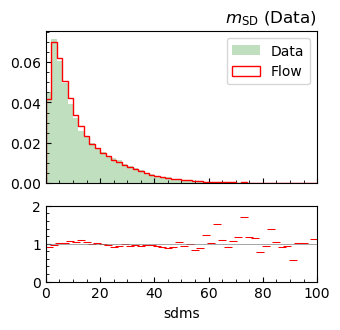

In [458]:
ratio_hist(dt[:, 4], dat_smp[:, 4], 
           labels = ['Data', 'Flow', r'sdms'],
           color = 'green',
           figsize = (w, h),
           title = r'$m_{\rm SD}$ (Data)',
           x_lim = (0, 100),
           filename = '../plots/zenodo/flows/{}/sdms.png'.format(experiment)
          )

## Sim 5

In [459]:
experiment = 'flows/sim/5'

In [460]:
ckpt = torch.load('flows/sim/5/ckpt_best')
flow.load_state_dict(ckpt['model_state_dict'])
flow.eval()

smp = flow.sample(n).detach().numpy()

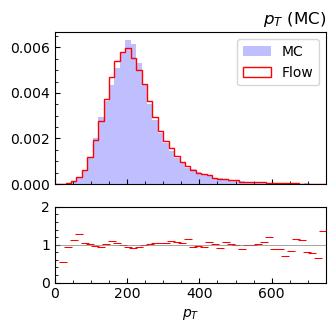

In [461]:
ratio_hist(mc[:, 0], smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/{}/pT.png'.format(experiment)
          )

/tmp/ipykernel_15872/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


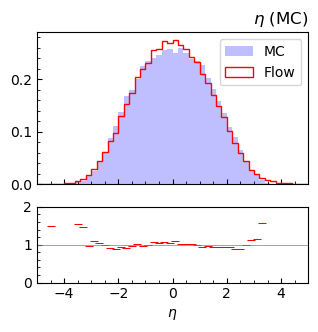

In [462]:
ratio_hist(mc[:, 1], smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/{}/eta.png'.format(experiment)
          )

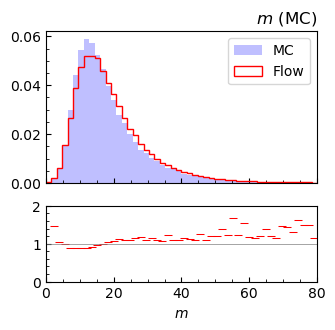

In [463]:
ratio_hist(mc[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$m$ (MC)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/{}/m.png'.format(experiment)
          )

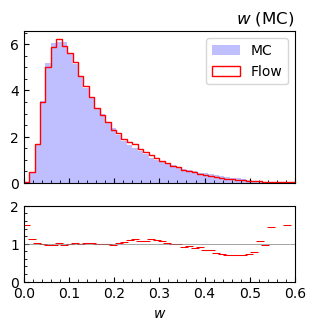

In [464]:
ratio_hist(mc[:, 3], smp[:, 3], 
           labels = ['MC', 'Flow', r'$w$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$w$ (MC)',
           x_lim = (0, 0.6),
           filename = '../plots/zenodo/flows/{}/w.png'.format(experiment)
          )

/tmp/ipykernel_15872/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


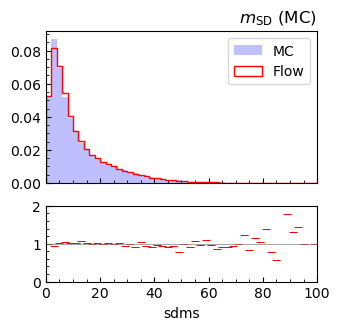

In [465]:
ratio_hist(mc[:, 4], smp[:, 4], 
           labels = ['MC', 'Flow', r'sdms'],
           color = 'blue',
           figsize = (w, h),
           title = r'$m_{\rm SD}$ (MC)',
           x_lim = (0, 100),
           filename = '../plots/zenodo/flows/{}/sdms.png'.format(experiment)
          )

## Load in 6-Vectors

In [322]:
# Load in data.
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

mc_pt =  mc['sim_jets'][:, 0] 
mc_eta = mc['sim_jets'][:, 1]
mc_phi = mc['sim_jets'][:, 2]
mc_m =   mc['sim_jets'][:, 3]
mc_w = mc['sim_widths']
mc_sdms = mc['sim_sdms']
mc_mults = mc['sim_mults']
mc_tau21 = mc['sim_tau2s'] / (mc_w + 10**-50)
mc_jm = np.log(mc_sdms**2 / mc_pt**2 + 10**-100)

jm_mask = mc_jm > -20
mc_pt = mc_pt[jm_mask]
mc_eta = mc_eta[jm_mask]
mc_phi = mc_phi[jm_mask]
mc_m = mc_m[jm_mask]
mc_w = mc_w[jm_mask]
mc_sdms = mc_sdms[jm_mask]
mc_mults = mc_mults[jm_mask]
mc_tau21 = mc_tau21[jm_mask]
mc_jm = mc_jm[jm_mask]

mc = np.vstack([mc_m, mc_mults, mc_w, mc_jm, mc_tau21, mc_pt]).T


dt = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dt_pt =  dt['sim_jets'][:, 0] 
dt_eta = dt['sim_jets'][:, 1]
dt_phi = dt['sim_jets'][:, 2]
dt_m =   dt['sim_jets'][:, 3]
dt_w = dt['sim_widths']
dt_sdms = dt['sim_sdms']
dt_mults = dt['sim_mults']
dt_tau21 = dt['sim_tau2s'] / (dt_w + 10**-50)
dt_jm = np.log(dt_sdms**2 / dt_pt**2 + 10**-100)

jm_mask = dt_jm > -20
dt_pt = dt_pt[jm_mask]
dt_eta = dt_eta[jm_mask]
dt_phi = dt_phi[jm_mask]
dt_m = dt_m[jm_mask]
dt_w = dt_w[jm_mask]
dt_sdms = dt_sdms[jm_mask]
dt_mults = dt_mults[jm_mask]
dt_tau21 = dt_tau21[jm_mask]
dt_jm = dt_jm[jm_mask]

dt = np.vstack([dt_m, dt_mults, dt_w, dt_jm, dt_tau21, dt_pt]).T

n, d = mc.shape

In [323]:
num_layers = 5
base_dist = StandardNormal(shape=[d])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=d))
    transforms.append(MaskedAffineAutoregressiveTransform(features=d, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

## Dat 6

In [324]:
experiment = 'flows/dat/6'

In [325]:
ckpt = torch.load('flows/dat/6/best/ckpt_99')
flow.load_state_dict(ckpt['model_state_dict'])

smp = flow.sample(n).detach().numpy()

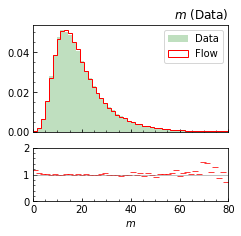

In [326]:
ratio_hist(dt[:, 0], smp[:, 0], 
           labels = ['Data', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'$m$ (Data)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/{}/m.png'.format(experiment)
          )

/tmp/ipykernel_1609645/1038232073.py:33: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


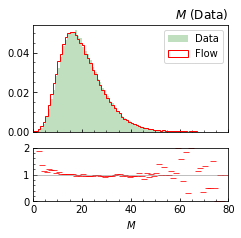

In [327]:
ratio_hist(dt[:, 1], smp[:, 1], 
           labels = ['Data', 'Flow', r'$M$'],
           color = 'green',
           figsize = (w, h),
           title = r'$M$ (Data)',
           x_lim = (0, 80),
           n_bins = 81,
           filename = '../plots/zenodo/flows/{}/mults.png'.format(experiment)
          )

/tmp/ipykernel_1609645/1038232073.py:33: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_1609645/1038232073.py:33: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


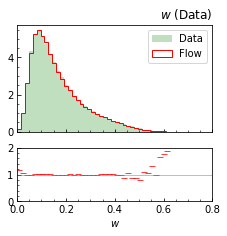

In [328]:
ratio_hist(dt[:, 2], smp[:, 2], 
           labels = ['Data', 'Flow', r'$w$'],
           color = 'green',
           figsize = (w, h),
           title = r'$w$ (Data)',
           x_lim = (0, 0.8),
           filename = '../plots/zenodo/flows/{}/w.png'.format(experiment)
          )

/tmp/ipykernel_1609645/1038232073.py:33: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


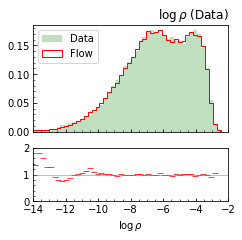

In [329]:
ratio_hist(dt[:, 3], smp[:, 3], 
           labels = ['Data', 'Flow', r'$\log \rho$'],
           color = 'green',
           figsize = (w, h),
           title = r'$\log \rho$ (Data)',
           x_lim = (-14, -2),
           filename = '../plots/zenodo/flows/{}/sdjm.png'.format(experiment)
          )

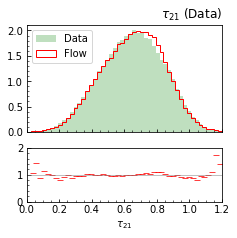

In [330]:
ratio_hist(dt[:, 4], smp[:, 4], 
           labels = ['Data', 'Flow', r'$\tau_{21}$'],
           color = 'green',
           figsize = (w, h),
           title = r'$\tau_{21}$ (Data)',
           x_lim = (0, 1.2),
           filename = '../plots/zenodo/flows/{}/nsr.png'.format(experiment)
          )

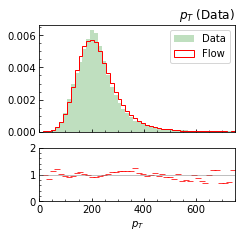

In [331]:
ratio_hist(mc[:, 5], smp[:, 5], 
           labels = ['Data', 'Flow', r'$p_T$'],
           color = 'Green',
           figsize = (w, h),
           title = r'$p_T$ (Data)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/{}/pT.png'.format(experiment)
          )

## Sim 6

In [332]:
experiment = 'flows/sim/6'

In [333]:
ckpt = torch.load('flows/sim/6/best/ckpt_99')
flow.load_state_dict(ckpt['model_state_dict'])
flow.eval()

smp = flow.sample(n).detach().numpy()

In [334]:
-flow.log_prob(inputs=mc.astype('float32')).mean()

tensor(9.7849, grad_fn=<NegBackward0>)

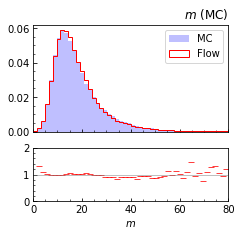

In [335]:
ratio_hist(mc[:, 0], smp[:, 0], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$m$ (MC)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/{}/m.png'.format(experiment)
          )

/tmp/ipykernel_1609645/1038232073.py:33: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_1609645/1038232073.py:33: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


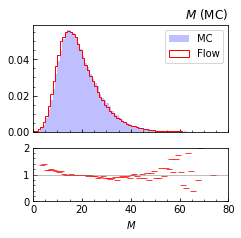

In [336]:
ratio_hist(mc[:, 1], smp[:, 1], 
           labels = ['MC', 'Flow', r'$M$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$M$ (MC)',
           x_lim = (0, 80),
           n_bins = 81,
           filename = '../plots/zenodo/flows/{}/mults.png'.format(experiment)
          )

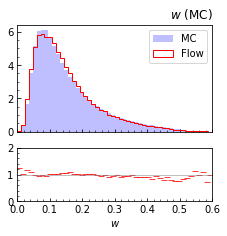

In [337]:
ratio_hist(mc[:, 2], smp[:, 2], 
           labels = ['MC', 'Flow', r'$w$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$w$ (MC)',
           x_lim = (0, 0.6),
           filename = '../plots/zenodo/flows/{}/w.png'.format(experiment)
          )

/tmp/ipykernel_1609645/1038232073.py:33: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_1609645/1038232073.py:33: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


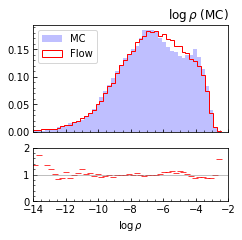

In [338]:
ratio_hist(mc[:, 3], smp[:, 3], 
           labels = ['MC', 'Flow', r'$\log \rho$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$\log \rho$ (MC)',
           x_lim = (-14, -2),
           filename = '../plots/zenodo/flows/{}/sdjm.png'.format(experiment)
          )

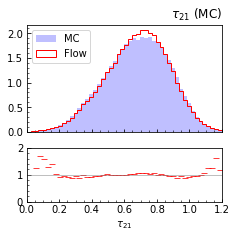

In [339]:
ratio_hist(mc[:, 4], smp[:, 4], 
           labels = ['MC', 'Flow', r'$\tau_{21}$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$\tau_{21}$ (MC)',
           x_lim = (0, 1.2),
           filename = '../plots/zenodo/flows/{}/nsr.png'.format(experiment)
          )

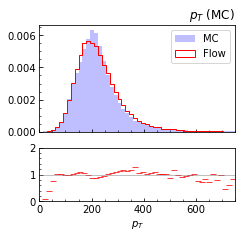

In [340]:
ratio_hist(mc[:, 5], smp[:, 5], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'blue',
           figsize = (w, h),
           title = r'$p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/{}/pT.png'.format(experiment)
          )

# Scratch

In [500]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")
dt = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

In [503]:
mc['sim_mults']

array([17, 27, 33, ..., 24, 11, 29])

In [539]:
for i in tqdm.trange(100001, 200000):
    print(i)


 70%|██████▉   | 69659/99999 [00:00<00:00, 363608.29it/s]

100001
100002
100003
100004
100005
100006
100007
100008
100009
100010
100011
100012
100013
100014
100015
100016
100017
100018
100019
100020
100021
100022
100023
100024
100025
100026
100027
100028
100029
100030
100031
100032
100033
100034
100035
100036
100037
100038
100039
100040
100041
100042
100043
100044
100045
100046
100047
100048
100049
100050
100051
100052
100053
100054
100055
100056
100057
100058
100059
100060
100061
100062
100063
100064
100065
100066
100067
100068
100069
100070
100071
100072
100073
100074
100075
100076
100077
100078
100079
100080
100081
100082
100083
100084
100085
100086
100087
100088
100089
100090
100091
100092
100093
100094
100095
100096
100097
100098
100099
100100
100101
100102
100103
100104
100105
100106
100107
100108
100109
100110
100111
100112
100113
100114
100115
100116
100117
100118
100119
100120
100121
100122
100123
100124
100125
100126
100127
100128
100129
100130
100131
100132
100133
100134
100135
100136
100137
100138
100139
100140
100141
100142
100143

100%|██████████| 99999/99999 [00:00<00:00, 377509.78it/s]


175431
175432
175433
175434
175435
175436
175437
175438
175439
175440
175441
175442
175443
175444
175445
175446
175447
175448
175449
175450
175451
175452
175453
175454
175455
175456
175457
175458
175459
175460
175461
175462
175463
175464
175465
175466
175467
175468
175469
175470
175471
175472
175473
175474
175475
175476
175477
175478
175479
175480
175481
175482
175483
175484
175485
175486
175487
175488
175489
175490
175491
175492
175493
175494
175495
175496
175497
175498
175499
175500
175501
175502
175503
175504
175505
175506
175507
175508
175509
175510
175511
175512
175513
175514
175515
175516
175517
175518
175519
175520
175521
175522
175523
175524
175525
175526
175527
175528
175529
175530
175531
175532
175533
175534
175535
175536
175537
175538
175539
175540
175541
175542
175543
175544
175545
175546
175547
175548
175549
175550
175551
175552
175553
175554
175555
175556
175557
175558
175559
175560
175561
175562
175563
175564
175565
175566
175567
175568
175569
175570
175571
175572
17557